In [31]:
import requests

url = "https://networks.skewed.de/net/add_health/files/comm68.csv.zip"
token = "caihituvWarorgyar0Frik"

headers = {"WWW-Authenticate": token}

r = requests.get(url, headers=headers)
print("Status code:", r.status_code)
print("Content-Type:", r.headers.get("content-type"))

if r.status_code == 200:
    with open("comm68.csv.zip", "wb") as f:
        f.write(r.content)
    print("Downloaded successfully!")
else:
    print(f"Failed: {r.status_code}")
    print(r.text[:500])

Status code: 200
Content-Type: application/zip
Downloaded successfully!


In [3]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from tqdm import trange
from scipy import stats

In [2]:
nodes_df = pd.read_csv("nodes.csv")  # contains node IDs and metadata
edges_df = pd.read_csv("edges.csv")  # contains source/target (and maybe weights)

node_columns = ['index', 'sex', 'race', 'grade', 'school', '_pos']
edge_columns = ['source', 'target', 'activities']

nodes_df.columns = node_columns
edges_df.columns = edge_columns

# print(nodes_df.head())
# print(edges_df.head())
G = nx.Graph()

for _, row in nodes_df.iterrows():
    node_id = row['index']
    attr = row.to_dict()
    G.add_node(node_id, **attr)
    
for _, row in edges_df.iterrows():
    src = row['source']
    target = row['target']
    attr = row.drop(['source', 'target']).to_dict()
    G.add_edge(src, target, **attr)

print(G)
edges_df

Graph with 1460 nodes and 3875 edges


,source,target,activities
0,0,596,1
1,0,606,1
2,0,995,4
3,1,852,5
4,1,1025,1
...,...,...,...
4844,1459,1223,2
4845,1459,1261,5
4846,1459,1267,3
4847,1459,1273,4


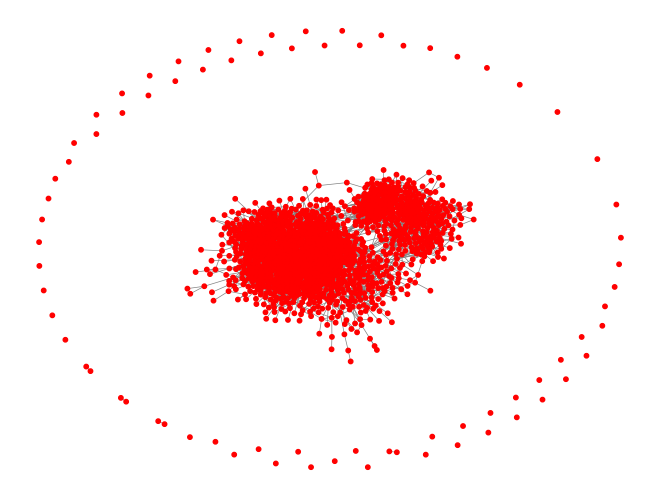

In [9]:
positions = nodes_df['_pos'].to_dict()

def draw_graph_preset_pos(G, positions, special_nodes: list):
    pos = {}
    for node, string_val in positions.items():
        # Extract numbers from string and convert to list
        nums = string_val.strip('array([])').split(',')
        pos[node] = [float(x.strip()) for x in nums]
    
    nx.draw(G, pos=pos,
        # NODES
        node_size= [30 if node in special_nodes else 10 for node in G.nodes()],
        node_color = ['cyan' if node in special_nodes else 'red' for node in G.nodes()],
        node_shape='o',             # 'o', 's', '^', 'v', '<', '>', 'd', etc.
        
        # EDGES
        edge_color='gray',          # Color or list per edge
        width=0.5,                  # Edge width, single or list per edge
        style='solid',              # 'solid', 'dashed', 'dotted', 'dashdot'
        
        # GENERAL
        alpha=1,                  # Transparency (0-1)
        with_labels=False,           # Show node labels
        font_size=10,               # Label font size
        font_color='black',         # Label color
        font_weight='normal',
            )
    
    plt.savefig('snapshots/network_messy.png', 
        dpi=300,              # Higher resolution (default is 100)
        bbox_inches='tight',  # Remove extra whitespace
        transparent=False,     # Transparent background
        format='png'          # 'png', 'pdf', 'svg', 'jpg'
    )
draw_graph_preset_pos(G, positions, [])

# EDA of the network
Edge/node count

In [5]:
print(G.number_of_nodes(), G.number_of_edges())

1460 3875


Max degree: 19. Min degree: 0


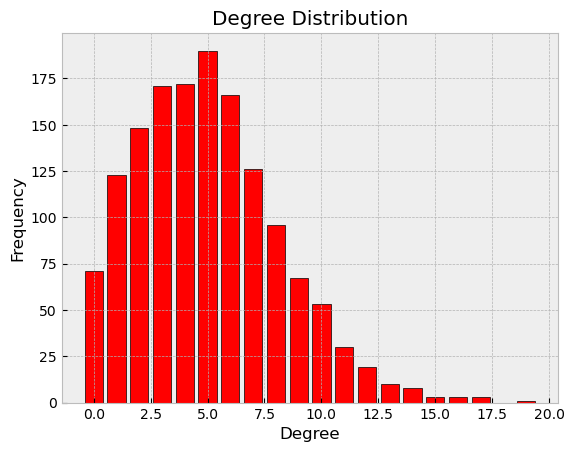

In [91]:
from collections import Counter

degree_dist = []
for node in G.nodes:
    degree_dist.append(nx.degree(G, node))
    
print(f'Max degree: {max(degree_dist)}. Min degree: {min(degree_dist)}')

degrees = [d for n, d in G.degree()]
degree_counts = Counter(degrees)

plt.bar(degree_counts.keys(), degree_counts.values(), edgecolor='black', color = 'red')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

In [52]:
# Average clustering of nodes
nx.average_clustering(G)

0.16292057226034493

## We need to pre-process the network. We remove unconnected nodes and any connections through activity 5.

In [62]:
pre_nodes_df = nodes_df.copy()
pre_edges_df = edges_df.copy()

pre_edges_df = pre_edges_df[pre_edges_df['activites'] != 5]

G = nx.Graph()

for _, row in pre_nodes_df.iterrows():
    node_id = row['index']
    attr = row.to_dict()
    G.add_node(node_id, **attr)
    
for _, row in pre_edges_df.iterrows():
    src = row['source']
    target = row['target']
    attr = row.drop(['source', 'target']).to_dict()
    G.add_edge(src, target, **attr)

In [63]:
largest_cc = max(nx.connected_components(G), key = len)
G_main = G.subgraph(largest_cc).copy()

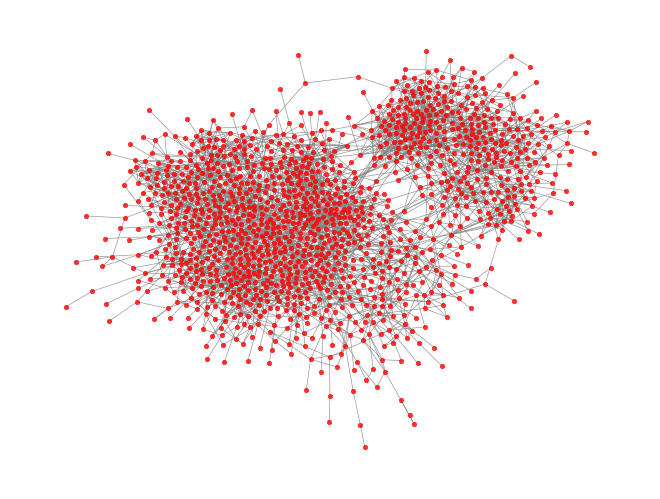

In [78]:
pre_nodes_df = pre_nodes_df[pre_nodes_df['index'].isin(list(G_main.nodes))]

pre_positions = pre_nodes_df['_pos'].to_dict()

draw_graph_preset_pos(G_main, pre_positions)

In [79]:
print(G.number_of_nodes(), G.number_of_edges())

1460 3656


In [88]:
degree_dist = []
for node in G_main.nodes:
    degree_dist.append(nx.degree(G, node))
    
print(f'Max degree: {max(degree_dist)}. Min degree: {min(degree_dist)}')

Max degree: 19. Min degree: 1


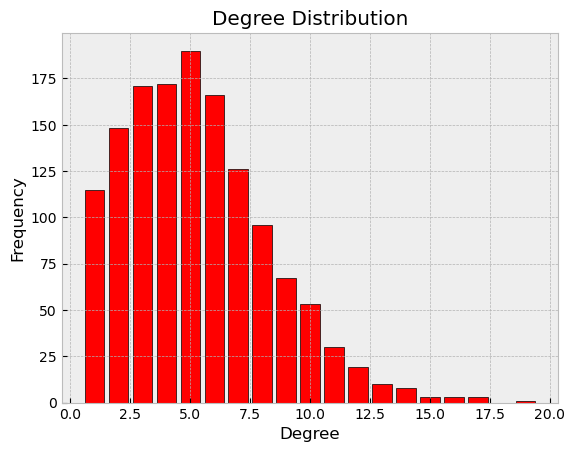

In [92]:
degrees = [d for n, d in G_main.degree()]
degree_counts = Counter(degrees)

plt.bar(degree_counts.keys(), degree_counts.values(), edgecolor='black', color = 'red')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

In [95]:
# Average clustering of nodes
nx.average_clustering(G_main)

0.15671052829223311

In [99]:
nx.diameter(G_main)

13

In [98]:
# Compute the average shortest path for the network
nx.average_shortest_path_length(G_main)

5.6258781181458515

In [105]:
# Compute assortativity coefficient
print(f'School Assortativity: {nx.attribute_assortativity_coefficient(G_main, attribute="school")}')
print(f'Grade Assortativity: {nx.attribute_assortativity_coefficient(G_main, attribute="grade")}')
print(f'Race Assortativity: {nx.attribute_assortativity_coefficient(G_main, attribute="race")}')
print(f'Sex Assort. : {nx.attribute_assortativity_coefficient(G_main, attribute="sex")}')
print(f'Assortativity by degree: {nx.degree_assortativity_coefficient(G)}')

School Assortativity: 0.9654509225035363
Grade Assortativity: 0.7269921817921237
Race Assortativity: 0.42494000623882433
Sex Assort. : 0.1263803695449494
Assortativity by degree: 0.20954746607792132


Since we simulate disease spread, we can identify 'bridges'.

      node  betweenness
869    923     0.048925
1274  1349     0.040535
505    536     0.038716
1354  1433     0.038440
364    391     0.034817
1139  1208     0.032269
647    686     0.028979
531    564     0.026150
1079  1147     0.025208
1223  1296     0.023016


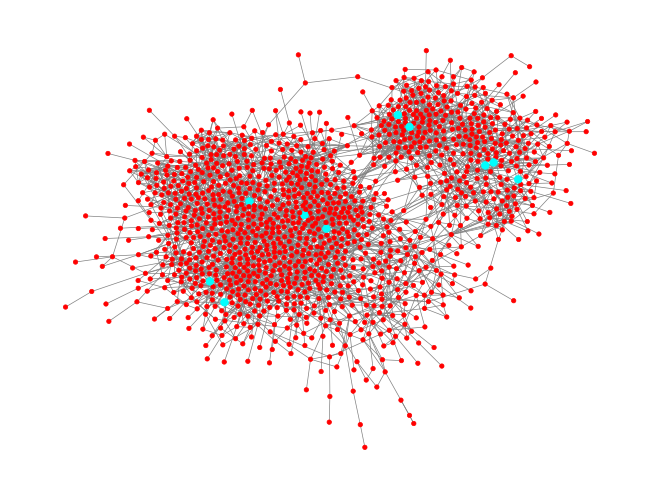

In [121]:
betweenness = nx.betweenness_centrality(G_main)

# Convert to DataFrame
df = pd.DataFrame(betweenness.items(), columns=['node', 'betweenness'])
df = df.sort_values('betweenness', ascending=False)

# Top 10 nodes
print(df.head(10))

# Get the top node
top_node = df.iloc[:10]['node']

draw_graph_preset_pos(G_main, pre_positions, top_node)

# Simulation code

In [10]:
# PARAMETERS
# -------------------------
beta_base = 0.03         # baseline per-contact infection prob
gamma = 0.1              # recovery probability per time step
steps = 100              # number of time steps per run
initial_infected_frac = 0.01
n_runs = 200             # runs per greeting (increase for more precision)

greeting_beta = {
    'hug': 1.0,
    'handshake': 0.5,
    'fistbump': 0.2
}

activity_beta = {
    1: 1.2,   # house visit
    2: 1.0,   # after school
    3: 1.1,   # weekend
    4: 1.0,   # talk about problem
    5: 0.0    # telephone / no infection
}

def get_activity_attr(G, u, v):
    data = G[u][v]
    return data.get('activities', None)

# -------------------------
# Single SIS run
# -------------------------
def run_SIS_single(G, greeting, beta_base, gamma, steps, initial_infected_frac, rng=random):
    nodes = list(G.nodes())
    n = len(nodes)
    # initialize states: 0=S, 1=I
    state = {v: 0 for v in nodes}
    n_seed = max(1, int(initial_infected_frac * n))
    seed = rng.sample(nodes, n_seed)
    for s in seed:
        state[s] = 1
    I = set(seed)

    infected_counts = []
    peak = 0
    time_to_peak = None
    time_to_10pct = None

    for t in range(steps):
        newly_infected = set()
        newly_recovered = set()

        # transmission & recovery
        for u in list(I):
            # infection
            for v in G.neighbors(u):
                if state[v] == 0:  # susceptible
                    act = get_activity_attr(G, u, v)
                    act_w = activity_beta.get(act, 1.0) if act is not None else 1.0
                    beta_edge = beta_base * greeting_beta[greeting] * act_w
                    if rng.random() < beta_edge:
                        newly_infected.add(v)
            # recovery
            if rng.random() < gamma:
                newly_recovered.add(u)

        # update states
        for v in newly_infected:
            state[v] = 1
        for u in newly_recovered:
            state[u] = 0  # recovered → susceptible in SIS
        I = (I | newly_infected) - newly_recovered

        infected_counts.append(len(I))

        # metrics
        if len(I) > peak:
            peak = len(I)
            time_to_peak = t
        if time_to_10pct is None and len(I) >= 0.10 * n:
            time_to_10pct = t

    peak_frac = peak / n
    if time_to_peak is None:
        time_to_peak = np.nan
    if time_to_10pct is None:
        time_to_10pct = np.nan

    return {
        'infected_counts': infected_counts,
        'peak_frac': peak_frac,
        'time_to_peak': time_to_peak,
        'time_to_10pct': time_to_10pct
    }

# -------------------------
# Batch runner: run many sims for a greeting
# -------------------------
def run_batch(G, greeting, n_runs=n_runs, seed_base=42):
    rng = random.Random()
    results = []
    for i in trange(n_runs, desc=f"runs for {greeting}"):
        rng.seed(seed_base + i)
        res = run_SIS_single(G, greeting, beta_base, gamma, steps, initial_infected_frac, rng=rng)
        results.append(res)
    return results

# -------------------------
# Summarize batch output
# -------------------------
def summarize_results(batch_results):
    finals = np.array([r['final_size'] for r in batch_results])
    peaks = np.array([r['peak_frac'] for r in batch_results])
    tpeak = np.array([r['time_to_peak'] for r in batch_results])
    t10 = np.array([r['time_to_10pct'] for r in batch_results])

    summary = {
        'final_mean': np.nanmean(finals),
        'final_std': np.nanstd(finals, ddof=1),
        'peak_mean': np.nanmean(peaks),
        'peak_std': np.nanstd(peaks, ddof=1),
        'time_to_peak_mean': np.nanmean(tpeak),
        'time_to_peak_std': np.nanstd(tpeak[~np.isnan(tpeak)]) if np.any(~np.isnan(tpeak)) else np.nan,
        'time_to_10pct_mean': np.nanmean(t10),
        'time_to_10pct_std': np.nanstd(t10[~np.isnan(t10)]) if np.any(~np.isnan(t10)) else np.nan
    }
    return summary, finals, peaks, tpeak, t10


# Example usage

In [12]:
G_obs = G
greetings = ['hug','handshake','fistbump']
all_summaries = {}
all_raw = {}

for g in greetings:
    batch = run_batch(G_obs, g, n_runs=n_runs)
    summary, finals, peaks, tpeak, t10 = summarize_results(batch)
    all_summaries[g] = summary
    all_raw[g] = {'finals': finals, 'peaks': peaks, 'tpeak': tpeak, 't10': t10}
    print(f"\n=== {g.upper()} ===")
    print(f"final attack rate: {summary['final_mean']:.4f} ± {summary['final_std']:.4f}")
    print(f"peak prevalence:    {summary['peak_mean']:.4f} ± {summary['peak_std']:.4f}")
    print(f"time-to-peak (mean): {summary['time_to_peak_mean']:.2f} ± {summary['time_to_peak_std']:.2f}")
    print(f"time-to-10% (mean):  {summary['time_to_10pct_mean']:.2f} ± {summary['time_to_10pct_std']:.2f}")

# -------------------------
# Simple statistical comparisons: pairwise Mann-Whitney U (non-parametric)
# -------------------------
def compare_pairwise(name_a, name_b, all_raw, alpha=0.05):
    a = all_raw[name_a]['finals']
    b = all_raw[name_b]['finals']
    u, p = stats.mannwhitneyu(a, b, alternative='two-sided')
    return {'u': u, 'p': p, 'significant': p < alpha}

print("\nPairwise comparisons (final attack rate):")
pairs = [('hug','handshake'), ('hug','fistbump'), ('handshake','fistbump')]
for a,b in pairs:
    out = compare_pairwise(a,b, all_raw)
    print(f"{a} vs {b}: p = {out['p']:.4f}, significant={out['significant']}")

# -------------------------
# Plotting mean trajectories (optional)
# -------------------------
def plot_mean_trajectory(G, greeting, n_runs=50):
    # run fewer runs for trajectories (cheap)
    trajs = [run_SIS_single(G, greeting, beta_base, gamma, steps, initial_infected_frac)['infected_counts']
             for _ in range(n_runs)]
    trajs = np.array(trajs)
    mean_traj = trajs.mean(axis=0)
    q25 = np.percentile(trajs, 25, axis=0)
    q75 = np.percentile(trajs, 75, axis=0)

    plt.fill_between(range(len(mean_traj)), q25, q75, alpha=0.3)
    plt.plot(mean_traj, label=f"{greeting} mean infected")
    plt.xlabel("time step")
    plt.ylabel("number of infected")
    plt.legend()

plt.figure(figsize=(8,5))
for g in greetings:
    plot_mean_trajectory(G_obs, g, n_runs=80)
plt.title("Mean infection trajectories (one greeting at a time)")
plt.show()

runs for hug: 100%|██████████| 200/200 [00:39<00:00,  5.05it/s]


KeyError: 'final_size'

# Benchmarking and testing